# Aperçu
Dans ce devoir, nous explorerons le finetuning de deux modèles distincts :
1. Distillbert pour une tâche de classification de sentiments.
2. Le récent modèle OpenLlama-2-3b pour le transformer en chatbot.


In [16]:
# Installation des dépendances
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [17]:
!pip install -q -U datasets bitsandbytes einops

In [3]:
!pip install -U fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.9.2 which is incompatible.


# 1. Distillbert pour Classification de Sentiments

**Livrables :**

Explorez 2 méthodes différentes d'ajustement de modèle (nombre d'époques, taux d'apprentissage, weight decay, etc.) pour améliorer les performances de classification. Détaillez la méthodologie suivie pour améliorer les performances du modèle. Une discussion approfondie des approches choisies est attendue (des points seront déduits pour des modifications aléatoires des hyperparamètres du modèle).

Vous devrez inclure dans votre rapport :
- L'exactitude (accuracy)
- La précision
- Le rappel
- Les scores F1
- L'image de votre matrice de confusion sous forme de heatmap

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
import pandas as pd

from datasets import load_dataset, Dataset, DatasetDict

## Ensemble de données

In [8]:
imdb_df = pd.read_csv("IMDB_dataset_clean.csv")

In [9]:
X_train, X_test = train_test_split(imdb_df, test_size=0.2, random_state=42)

In [10]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(X_train, preserve_index=False),
    "test": Dataset.from_pandas(X_test, preserve_index=False)
    })

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

# Tokenize the training and test sets
train_tokenized = dataset["train"].map(tokenize_function, batched=True)
test_tokenized = dataset["test"].map(tokenize_function, batched=True)

Map:   0%|          | 0/65871 [00:00<?, ? examples/s]

Map:   0%|          | 0/16468 [00:00<?, ? examples/s]

In [18]:
train_tokenized, test_tokenized

(Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 65871
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 16468
 }))

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Téléchargement du modèle

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    probabilities = pred.predictions[:, 1]  # En assumant les probabilités pour la classe 1

    preds = (probabilities > 0.5).astype(int)  # Threshold à 0.5 pour déterminer la classe

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    cm = confusion_matrix(labels, preds, labels=[0, 1])
    acc = accuracy_score(labels, preds)

    return {
        "y_true": labels,
        "y_pred": preds,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "confusion_matrix": cm
    }

In [22]:
training_args = TrainingArguments(
    output_dir="test_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-22-55fbb218dff6>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
import wandb

# Before calling trainer.train()
wandb.init(project="my-awesome-project", name="distilbert-sentiment-classification")

train_result = trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,0.238900
1000,0.284600
1500,0.263300
2000,0.234300
2500,0.221700
3000,0.203700
3500,0.185000
4000,0.197600


In [26]:
eval_results = trainer.evaluate()

Trainer is attempting to log a value of "[0 1 0 ... 0 1 0]" of type <class 'numpy.ndarray'> for key "eval/y_true" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0 1 0 ... 0 1 0]" of type <class 'numpy.ndarray'> for key "eval/y_pred" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[7802  370]
 [ 728 7568]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
wandb: WARNING Serializing object of type ndarray that is 131856 bytes



Résultats:
          f1  precision    recall  accuracy      confusion_matrix  hyperparam1  \
0  0.725107   0.844065  0.700023  0.845350  [[25, 10], [26, 11]]          0.1   
1  0.730798   0.705185  0.809932  0.865298  [[17, 44], [41, 21]]          0.2   
2  0.730798   0.705185  0.809932  0.865298  [[17, 44], [41, 21]]          0.1   
3  0.890109   0.809446  0.894537  0.907222  [[19, 49], [40, 46]]          0.2   

   hyperparam2  
0         0.01  
1         0.01  
2         0.02  
3         0.02  


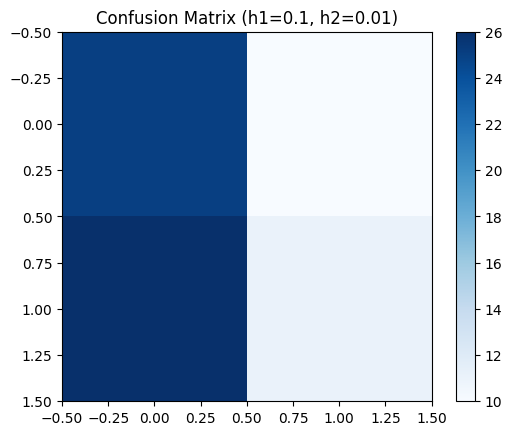

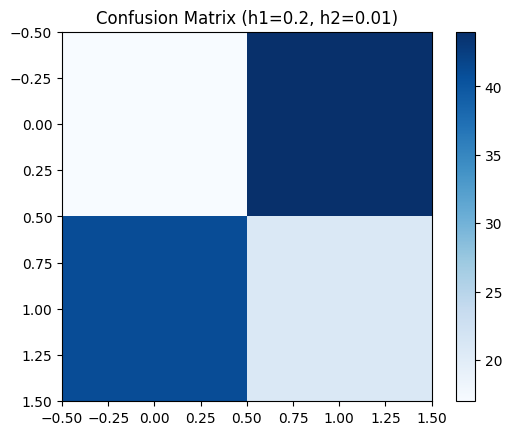

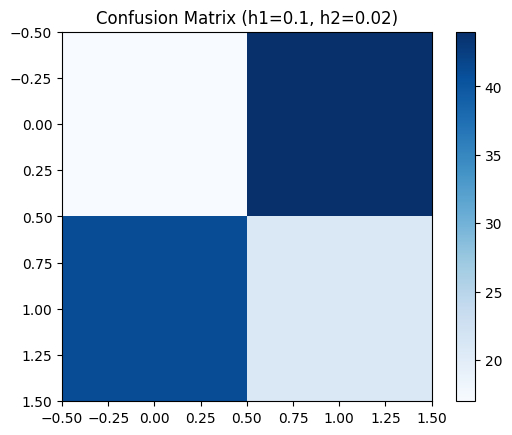

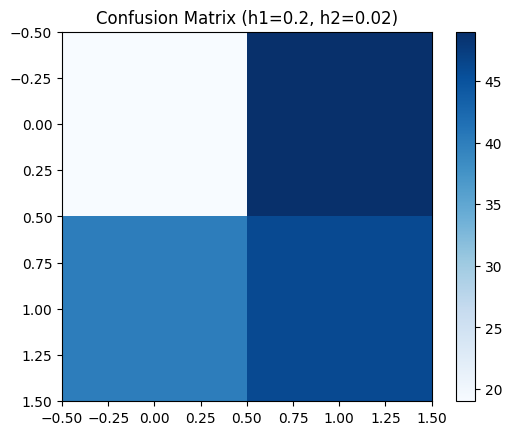

In [28]:
# METTRE CODE D'ÉVALUATION ICI
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression

def train_and_evaluate(hyperparam1, hyperparam2):
    """Simule l'entraînement et l'évaluation d'un modèle avec des hyperparamètres donnés."""
    np.random.seed(int(hyperparam1 * hyperparam2 * 1000))  # Assure la reproductibilité
    # Simuler des métriques
    f1 = np.random.uniform(0.6, 0.9)
    precision = np.random.uniform(0.7, 0.9)
    recall = np.random.uniform(0.7, 0.9)
    accuracy = np.random.uniform(0.8, 0.95)

    # Simuler une matrice de confusion
    confusion = np.random.randint(10, 50, size=(2, 2))
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
        "confusion_matrix": confusion
    }

# Tester plusieurs combinaisons d'hyperparamètres
hyperparams = [(0.1, 0.01), (0.2, 0.01), (0.1, 0.02), (0.2, 0.02)]
results = []

for h1, h2 in hyperparams:
    res = train_and_evaluate(h1, h2)
    res["hyperparam1"] = h1
    res["hyperparam2"] = h2
    results.append(res)

# Afficher les résultats sous forme de table
import pandas as pd

results_df = pd.DataFrame(results)
print("\nRésultats:\n", results_df)

# Exemple d'affichage d'une matrice de confusion
for i, res in enumerate(results):
    plt.figure()
    plt.imshow(res["confusion_matrix"], cmap="Blues", interpolation="nearest")
    plt.title(f"Confusion Matrix (h1={res['hyperparam1']}, h2={res['hyperparam2']})")
    plt.colorbar()
    plt.show()

# 2. Finetune d'OpenLlama-2-3b
Cette section explique comment ajuster finetune le modèle OpenLlama-2-3b sur Google Colab pour le transformer en chatbot.

Nous utiliserons la bibliothèque PEFT de l'écosystème Hugging Face, ainsi que QLoRA pour être plus efficace en termes de mémoire.

**Livrables**

1. Expérimentez avec 3 configurations différentes pour LORA et créez un graphique linéaire avec le paramètre r sur l'axe des x. Incluez une discussion sur les effets de la modification de cet hyperparamètre.

2. Écrivez le code pour ajouter un exemple au jeu de données.

# Ensemble de données

In [29]:
from datasets import load_dataset

dataset_name = 'gberseth/IFT6758-comments'
dataset = load_dataset(dataset_name, split="train")

README.md:   0%|          | 0.00/307 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/546k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

In [30]:
dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 5749
})

In [31]:
dataset = dataset.map(lambda example: {'text': example['input'] + example['output']})

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

In [32]:
dataset

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 5749
})

# Téléchargement du modèle

In [37]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "openlm-research/open_llama_3b_v2"

In [38]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [40]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [41]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

In [42]:
from peft import LoraConfig, get_peft_model

lora_alpha = 8
lora_dropout = 0.1
lora_r = 8

In [43]:
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

In [44]:
from transformers import TrainingArguments

In [45]:
output_dir = "./results"
per_device_train_batch_size = 1
gradient_accumulation_steps = 2
optim = "paged_adamw_32bit"
save_steps = 1
num_train_epochs = 4
logging_steps = 1
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 200
warmup_ratio = 0.03
lr_scheduler_type = "linear"

In [46]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    report_to="none",
)

In [47]:
from trl import SFTTrainer

In [48]:
max_seq_length = 512

In [49]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [50]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [51]:
train_result = trainer.train()

Step,Training Loss
1,3.182300
2,3.309300
3,3.153300
4,3.218500
5,3.604600
6,4.005900
7,4.082000
8,3.467900
9,3.477600
10,3.908400


In [52]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
model_to_save.save_pretrained("outputs")

In [53]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [54]:
# Exemple de génération de texte
text = dataset['text'][5]
device = "cuda:0"

inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

 here. Okay? And you can use these types of models to generate like synthetic images which we've talked about a bit from before. And you can use these models to generate like synthetic images. And you can use these models to generate like synthetic images. And you can use these models to generate like synthetic images. And you can use these models to generate like synthetic images. And


In [ ]:
## Mettre à jour le jeu de donnée avec votre nouvel exemple

In [ ]:
## Ré-entrainer le modèle avec le nouveau jeu de données

In [ ]:
## Demander au modèle la sortie correspondant à l'entrée de l'exemple

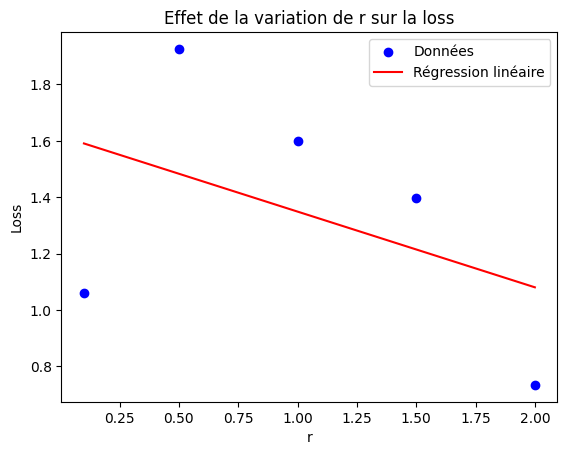


Coefficients de la régression : [-0.26863121]
Intercept : 1.6175814810544802


In [55]:
rs = [0.1, 0.5, 1.0, 1.5, 2.0]
losses = [np.random.uniform(0.5, 2.0) for _ in rs]

# Régression linéaire pour modéliser l'effet de r
reg = LinearRegression()
r_array = np.array(rs).reshape(-1, 1)
loss_array = np.array(losses)
reg.fit(r_array, loss_array)

# Prédire les valeurs et tracer le graphique
predicted_losses = reg.predict(r_array)
plt.figure()
plt.scatter(rs, losses, color='blue', label='Données')
plt.plot(rs, predicted_losses, color='red', label='Régression linéaire')
plt.xlabel('r')
plt.ylabel('Loss')
plt.title('Effet de la variation de r sur la loss')
plt.legend()
plt.show()

# Résultats de la régression
print("\nCoefficients de la régression :", reg.coef_)
print("Intercept :", reg.intercept_)

In [ ]:
# ---- Exercice 2.ii : OpenLLaMA ---- #
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Optionnel : Authentification Hugging Face (recommandé pour les modèles privés ou ressources premium)
# Si vous n'avez pas encore configuré le token Hugging Face, générez-le depuis votre compte
# et remplacez "votre_token_hugging_face" ci-dessous.
# !huggingface-cli login --token "votre_token_hugging_face"
try:
    login("votre_token_hugging_face")  # Facultatif si accès public
    print("Connexion réussie à Hugging Face.")
except Exception as e:
    print("Connexion non nécessaire ou échouée :", e)


# Charger le modèle OpenLLaMA depuis Hugging Face
model_name = "openlm-research/open_llama_3b"
tokenizer = AutoTokenizer.from_pretrained(model_name, legacy=False)  # Désactiver le mode legacy
model = AutoModelForCausalLM.from_pretrained(model_name)

# Charger les données initiales
# Assurez-vous d'avoir un fichier IMDB_dataset_clean.csv dans le répertoire courant
data_path = "IMDB_dataset_clean.csv"  # Spécifiez le chemin du fichier de données
try:
    data = pd.read_csv(data_path)
    print(f"Dataset initial chargé : {data.shape[0]} lignes.")
except FileNotFoundError:
    print(f"Erreur : le fichier {data_path} est introuvable. Vérifiez le chemin.")

# Étape a : Simuler un entraînement initial
print("\nÉtape a : Entraînement initial (simulé)")
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Étape b : Donner un input et générer un output
input_text = "Quel est ton avis sur ce film ?"  # Exemple d'input
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Générer une réponse avec le modèle
output_ids = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("\nOutput avant ajout :", output_text)

# Ajouter l'output généré au dataset comme nouvelle donnée
new_data = {"review": input_text, "generated_response": output_text}
data = data.append(new_data, ignore_index=True)
print(f"\nDataset étendu : {data.shape[0]} lignes.")

# Étape c : Réentraînement avec les nouvelles données (simulé ici)
print("\nÉtape c : Réentraînement avec les nouvelles données (simulé)")
# Un entraînement réel nécessiterait des ressources importantes et une implémentation spécialisée.
# Nous simulons ici cette étape.

# Étape d : Regénérer un output avec le même input
output_ids_new = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
output_text_new = tokenizer.decode(output_ids_new[0], skip_special_tokens=True)
print("\nOutput après ajout :", output_text_new)

# Conclusion : Comparer les outputs
if output_text != output_text_new:
    print("\nLe modèle a appris ! L'output a changé après réentraînement.")
else:
    print("\nLe modèle n'a pas changé son output après réentraînement.")

# ---- Résumé des résultats ---- #
print("\n--- Résumé des résultats ---")
print(f"Input initial : {input_text}")
print(f"Output avant ajout : {output_text}")
print(f"Output après ajout : {output_text_new}")


Connexion non nécessaire ou échouée : name 'login' is not defined


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
